In [44]:
%reload_ext autoreload
%autoreload 2

import os
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import initializers as init
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import activations, regularizers, constraints

from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import LabelEncoder

from util.preprocessing import *
from util.io import *

PATH = "./data/rt-polaritydata/"
PATH_TRANSLATE = "./data/rt-polaritydata-translated/"

TRANSLATION_ON_DISK=True

### Translate (English - English) 

In [2]:
if TRANSLATION_ON_DISK:
    docs,_ = get_documents(PATH_TRANSLATE)
else:
    docs, _ = get_documents(PATH)

    #only used once, since it is a bottleneck
    docs[0] = batch_translate_to_english(docs[0], batch_size=20)
    docs[1] = batch_translate_to_english(docs[1], batch_size=20)

    write_documents(docs, PATH_TRANSLATE, PATH)


In [3]:
data = pd.DataFrame(data = {
    "reviews": docs[0] + docs[1],
    "sentiment": [_[0]] * len(docs[0]) + [_[1]] * len(docs[1])
})


In [4]:
data.head()

,reviews,sentiment
0,"simplistic , silly and tedious .\n",neg
1,"it's so laddish and juvenile , only teenage bo...",neg
2,exploitative and largely devoid of the depth o...,neg
3,[garbus] discards the potential for pathologic...,neg
4,a visually flashy but narratively opaque and e...,neg


In [5]:
enc = LabelEncoder().fit(data.sentiment)
data.sentiment = enc.transform(data.sentiment)

In [6]:
data.head()

,reviews,sentiment
0,"simplistic , silly and tedious .\n",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0


In [7]:
word_set, docs = process_documents(data.reviews.to_list())

  0%|          | 0/10662 [00:00<?, ?it/s]

In [8]:
rev_word_set = { value:key for key,value in word_set.items()}

In [10]:
len(word_set), len(docs)

(17491, 10662)

In the paper (where the 1st version was used) they stated to have $18765$ words in the dataset. It is almost the same has what we obtained, $19545$. 
The algorithm used to translate might have been improved, or maybe the word filtering or word tokenizer might be slightly different.

## Generate word embeddings

In [120]:
from util.embedding import *

In [83]:
cooc = count_word_coocurrence(sentences, word_set, wsize=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14627/14627 [00:00<00:00, 137945.03it/s]


In [84]:
cooc

<19545x19545 sparse matrix of type '<class 'numpy.float64'>'
	with 172105 stored elements in Dictionary Of Keys format>

In [119]:
emb_model = get_cbow_model(word_set, 5, 100)

In [122]:
dataset = get_dataset(sentences, word_set, 5)

In [123]:
emb_in, emb_out = unwind(dataset)

In [124]:
emb_model.compile("adam", loss="sparse_categorical_crossentropy")

In [128]:
emb_model.fit(emb_in, emb_out, epochs=10, batch_size=32)

Epoch 1/10
568/568 [==============================] - 5s 8ms/step - loss: 0.7946
Epoch 2/10
568/568 [==============================] - 5s 8ms/step - loss: 0.7128
Epoch 3/10
568/568 [==============================] - 5s 8ms/step - loss: 0.6380
Epoch 4/10
568/568 [==============================] - 5s 8ms/step - loss: 0.5684
Epoch 5/10
568/568 [==============================] - 5s 8ms/step - loss: 0.5047
Epoch 6/10
568/568 [==============================] - 5s 8ms/step - loss: 0.4467
Epoch 7/10
568/568 [==============================] - 5s 8ms/step - loss: 0.3937
Epoch 8/10
568/568 [==============================] - 5s 8ms/step - loss: 0.3462
Epoch 9/10
568/568 [==============================] - 5s 8ms/step - loss: 0.3038
Epoch 10/10
568/568 [==============================] - 5s 8ms/step - loss: 0.2654


In [135]:
max(word_set.values())

19545

In [136]:
word_set["<PAD>"] =19546
word_set["[UNK]"] =19547

In [137]:
EMB_VECTORS = emb_model.get_weights()[0]

In [140]:
EMB_VECTORS = np.concatenate((EMB_VECTORS, [[0]*100], [[0]*100]))

## Load Word Vectors

In [11]:
word2vec = KeyedVectors.load_word2vec_format("util/embedding/GoogleNews-vectors-negative300.bin", binary=True)

In [12]:
len(word2vec.key_to_index)

3000000

In [13]:
def word2int(word):
    return word2vec.key_to_index[word]

def int2word(idx):
    return word2vec.index_to_key[idx]

- Add the **padding** and the **unknown** tokens to word2vec

In [14]:
EMB_DIM = word2vec.vector_size
PAD_TOKEN = "<PAD>"
UNKOWN_TOKEN = "[UNK]"
PAD_VEC = UNK_VEC = [0] * EMB_DIM


In [15]:
word2vec.add_vectors([PAD_TOKEN, UNKOWN_TOKEN], [PAD_VEC, UNK_VEC])

## Generate Vocabulary

In [16]:
train_set, test_set = train_test_split(data, test_size=0.1, random_state=13)

In [17]:
X_train = train_set.reviews.to_list()
X_test = test_set.reviews.to_list()

y_train = train_set.sentiment.to_numpy()
y_test = test_set.sentiment.to_numpy()

In [18]:
word_set, X_train = process_documents(X_train)

  0%|          | 0/9595 [00:00<?, ?it/s]

In [19]:
X_test = process_documents(X_test, return_vocab=False)

  0%|          | 0/1067 [00:00<?, ?it/s]

In [20]:
missing_words=[]
for word in word_set.keys():
    if word not in word2vec.key_to_index:
        missing_words.append(word)
len(missing_words)

1287

We can see that a significant number of words is missing. <br>
According to this [forum](https://groups.google.com/g/word2vec-toolkit/c/J3Skqbe3VwQ) we could create random vectors for those words.

Another option would be to simply replace those words with the 'UNKOWN' token.

In [21]:
#uncoment if we want random vectors for missing words
add_unknown_words(missing_words, word2vec, dev=0.25)

Map each sentence to the corresponding list of word indexes

In [22]:
X_train = map_to_index(X_train, word2vec.key_to_index)
X_test = map_to_index(X_test, word2vec.key_to_index)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Generate Trainable data

In [23]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([4791, 4804], dtype=int64))

- Pad training data to create a tabular data format for tensorflow

In [24]:
MAX_SEQUENCE_LENGTH = get_max_sequence_length(X_train)
MAX_SEQUENCE_LENGTH

29

In [25]:
X_train = pad_sentences(X_train, MAX_SEQUENCE_LENGTH, word2int(PAD_TOKEN))

In [26]:
X_test = pad_sentences(X_test, MAX_SEQUENCE_LENGTH, word2int(PAD_TOKEN))

In [27]:
X_train.shape, X_test.shape

((9595, 29), (1067, 29))

In [28]:
y_train.shape, y_test.shape

((9595,), (1067,))

## Model Training

In [38]:
def plot_layer_weights_at(model, layer_index):
    w = model.get_weights()[layer_index]
    plt.hist(w)

In [22]:
def get_output_at(model, layer_index, data):
    for i in range(layer_index):
        data = model.get_layer(index=i)(data)
    return data

In [23]:
def plot_out_at(model, layer_index, data):
    data = np.array(get_output_at(model, layer_index, data))
    print(data.shape)
    
    plt.axis("off")
    plt.imshow(data[0], cmap="gray")

In [30]:
vocab_pos = []
for w in word_set:
    if w in word2vec.key_to_index:
        vocab_pos.append(word2int(w))
vocab_pos += list(map(word2int, [UNKOWN_TOKEN, PAD_TOKEN]))

In [31]:
VOCAB_SIZE = len(vocab_pos)
EMB_MATRIX = word2vec.vectors[vocab_pos]

In [32]:
EMB_MATRIX.shape

(16652, 300)

In [28]:
def get_k_nearest(idx, k=5):
    word_idx = vocab_pos[idx]
    print(int2word(word_idx))
    
    dists = [ 
        euclidean(EMB_MATRIX[idx], EMB_MATRIX[other]) for other in range(len(vocab_pos)) 
    ]
    order = np.argsort(dists)[1:k+1]
    
    correct_idx = np.array(vocab_pos)[order]
    return [ int2word(i) for i in correct_idx ]


def get_k_nearest_from_embedding(embed, idx, k=5):
    word_idx = vocab_pos[idx]
    print(int2word(word_idx))
    
    dists = [ 
        euclidean(embed[idx], embed[other]) for other in range(len(vocab_pos)) 
    ]
    order = np.argsort(dists)[1:k+1]
    
    correct_idx = np.array(vocab_pos)[order]
    return [ int2word(i) for i in correct_idx ]

In [74]:
cnn = models.Sequential([
    layers.InputLayer(input_shape=MAX_SEQUENCE_LENGTH),
    layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMB_MATRIX.shape[1],
        embeddings_initializer=init.Constant(EMB_MATRIX),
        trainable=True,
    ),
    layers.Dropout(0.4),
    
    layers.Conv1D(32, kernel_size=3, activation=layers.LeakyReLU(), kernel_constraint="unit_norm"),
    layers.MaxPool1D(),
    
    layers.Conv1D(64, kernel_size=3, activation=layers.LeakyReLU()),
    layers.GlobalMaxPool1D(),
    
    layers.Dropout(0.4),
    layers.Dense(256, activation=layers.LeakyReLU()),
    layers.Dropout(0.2),
    layers.Dense(
        units=1, activation="sigmoid", activity_regularizer="l2"
    )
])
cnn.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])

In [75]:
train_history = cnn.fit(
    x=X_train,
    y=y_train, 
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
300/300 [==============================] - 6s 18ms/step - loss: 0.7496 - accuracy: 0.5067 - val_loss: 0.6939 - val_accuracy: 0.5248
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.6990 - accuracy: 0.5197 - val_loss: 0.6847 - val_accuracy: 0.5708
Epoch 3/20
300/300 [==============================] - 5s 17ms/step - loss: 0.6708 - accuracy: 0.5920 - val_loss: 0.6395 - val_accuracy: 0.6336
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 0.5808 - accuracy: 0.6980 - val_loss: 0.5772 - val_accuracy: 0.7001
Epoch 5/20
300/300 [==============================] - 5s 16ms/step - loss: 0.4818 - accuracy: 0.7737 - val_loss: 0.5782 - val_accuracy: 0.6870
Epoch 6/20
300/300 [==============================] - 5s 16ms/step - loss: 0.3931 - accuracy: 0.8216 - val_loss: 0.5789 - val_accuracy: 0.7151
Epoch 7/20
300/300 [==============================] - 5s 16ms/step - loss: 0.3309 - accuracy: 0.8543 - val_loss: 0.6142 - val_accuracy: 0.7085

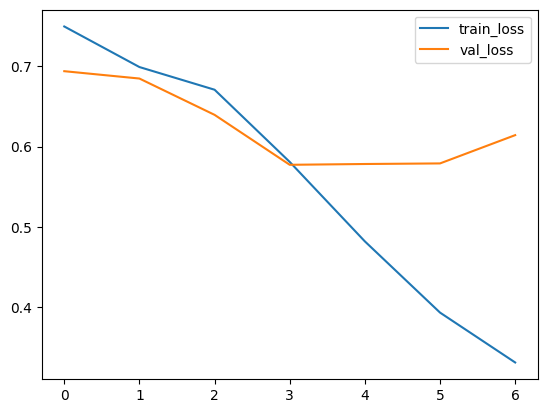

In [85]:
plt.plot(train_history.history["loss"], label="train_loss")
plt.plot(train_history.history["val_loss"], label="val_loss")
plt.legend()

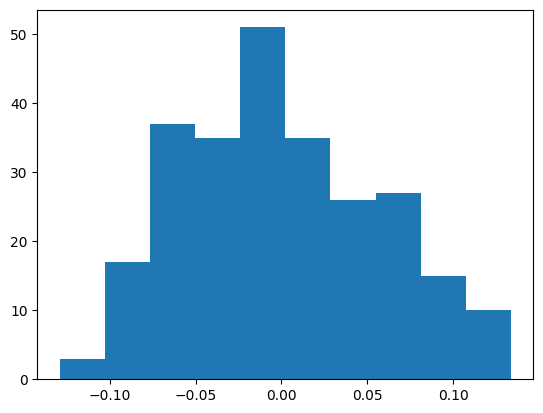

In [76]:
plot_layer_weights_at(cnn, -2)

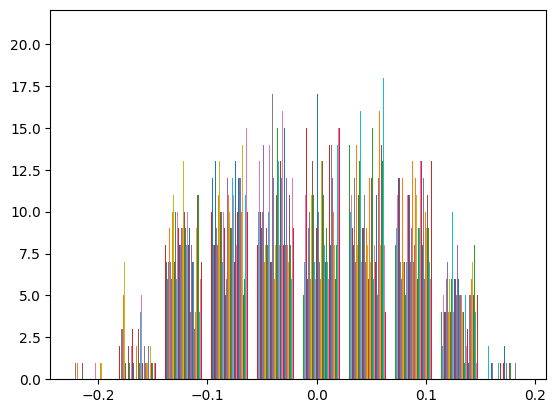

In [78]:
plot_layer_weights_at(cnn, -4)

In [80]:
cnn.get_weights()[-4].shape

(64, 256)